<a href="https://colab.research.google.com/github/SathyaSudha-96/HeatFlux/blob/main/notebooks/TorchIO_tutorial.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# TorchIO: a tutorial

In this tutorial, we will train a [3D U-Net](https://link.springer.com/chapter/10.1007/978-3-319-46723-8_49) to perform brain segmentation from T1-weighted MRI using the [Information eXtraction from Images (IXI) dataset](https://brain-development.org/ixi-dataset/), a publicly available dataset of almost 600 subjects.

## Setup

In [1]:
# Config
seed = 42  # for reproducibility
training_split_ratio = 0.9  # use 90% of samples for training, 10% for testing
num_epochs = 5

# If the following values are False, the models will be downloaded and not computed
compute_histograms = False
train_whole_images = False 
train_patches = False

Install some PyPI packages:

In [2]:
!pip install --quiet --upgrade pip
!pip install --quiet unet==0.7.7
!pip install --quiet torchio==0.18.48
!apt -qq install tree

     |████████████████████████████████| 1.6 MB 10.9 MB/s 
     |████████████████████████████████| 151 kB 12.1 MB/s 
     |████████████████████████████████| 48.4 MB 5.1 kB/s 
The following NEW packages will be installed:
  tree
0 upgraded, 1 newly installed, 0 to remove and 37 not upgraded.
Need to get 40.7 kB of archives.
After this operation, 105 kB of additional disk space will be used.
Selecting previously unselected package tree.
(Reading database ... 155047 files and directories currently installed.)
Preparing to unpack .../tree_1.7.0-5_amd64.deb ...
Unpacking tree (1.7.0-5) ...
Setting up tree (1.7.0-5) ...
Processing triggers for man-db (2.8.3-2ubuntu0.1) ...


Import modules:

In [3]:
import enum
import time
import random
import multiprocessing
from pathlib import Path

import torch
import torchvision
import torchio as tio
import torch.nn.functional as F

import numpy as np
from unet import UNet
from scipy import stats
import matplotlib.pyplot as plt

from IPython import display
from tqdm.notebook import tqdm

random.seed(seed)
torch.manual_seed(seed)
%config InlineBackend.figure_format = 'retina'
num_workers = multiprocessing.cpu_count()
plt.rcParams['figure.figsize'] = 12, 6

print('Last run on', time.ctime())
print('TorchIO version:', tio.__version__)

Last run on Sat Oct  2 18:15:42 2021
TorchIO version: 0.18.48


## Data

### Dataset

I downloaded the [IXI](https://brain-development.org/ixi-dataset/) dataset, segmented all brains using [ROBEX](https://ieeexplore.ieee.org/document/5742706), affine-registered everything to an MNI template with [NiftyReg](https://github.com/KCL-BMEIS/niftyreg), resampled everything into a space with a very large voxel spacing and funny orientation with [ITK](https://itk.org/) and uploaded a zip file to Dropbox.
It will be our medical-images MNIST dataset.

It can also be instantiated directly using [`torchio.datasets.IXITiny`](https://torchio.readthedocs.io/datasets.html#ixitiny), but we will do everything manually here.

In [4]:
# Dataset
dataset_url = 'https://www.dropbox.com/s/ogxjwjxdv5mieah/ixi_tiny.zip?dl=0'
dataset_path = 'ixi_tiny.zip'
dataset_dir_name = 'ixi_tiny'
dataset_dir = Path(dataset_dir_name)
histogram_landmarks_path = 'landmarks.npy'

In [5]:
if not dataset_dir.is_dir():
    !curl --silent --output {dataset_path} --location {dataset_url} 
    !unzip -qq {dataset_path}
!tree -d {dataset_dir_name}

ixi_tiny
├── image
└── label

2 directories


### [`SubjectsDataset`](https://torchio.readthedocs.io/data/dataset.html)

This is one of the most important classes in the library. It inherits from `torch.utils.data.Dataset`. It receives as input a list of [`torchio.Subject`](https://torchio.readthedocs.io/data/subject.html#subject) instances and an optional [`torchio.transforms.Transform`](https://torchio.readthedocs.io/transforms/transforms.html#torchio.transforms.Transform). 

The inputs to the subject class are instances of `torchio.Image`, such as [`torchio.ScalarImage`](https://torchio.readthedocs.io/data/image.html#scalarimage) or [`torchio.LabelMap`](https://torchio.readthedocs.io/data/image.html#labelmap). The image class will be used by the transforms to decide whether or not to perform the operation. For example, spatial transforms must apply to both, but intensity transforms must apply to scalar images only.

In [6]:
images_dir = dataset_dir / 'image'
labels_dir = dataset_dir / 'label'
image_paths = sorted(images_dir.glob('*.nii.gz'))
label_paths = sorted(labels_dir.glob('*.nii.gz'))
assert len(image_paths) == len(label_paths)

subjects = []
for (image_path, label_path) in zip(image_paths, label_paths):
    subject = tio.Subject(
        mri=tio.ScalarImage(image_path),
        brain=tio.LabelMap(label_path),
    )
    subjects.append(subject)
dataset = tio.SubjectsDataset(subjects)
print('Dataset size:', len(dataset), 'subjects')

Dataset size: 566 subjects


Let's take a look at one of the subjects in the dataset.

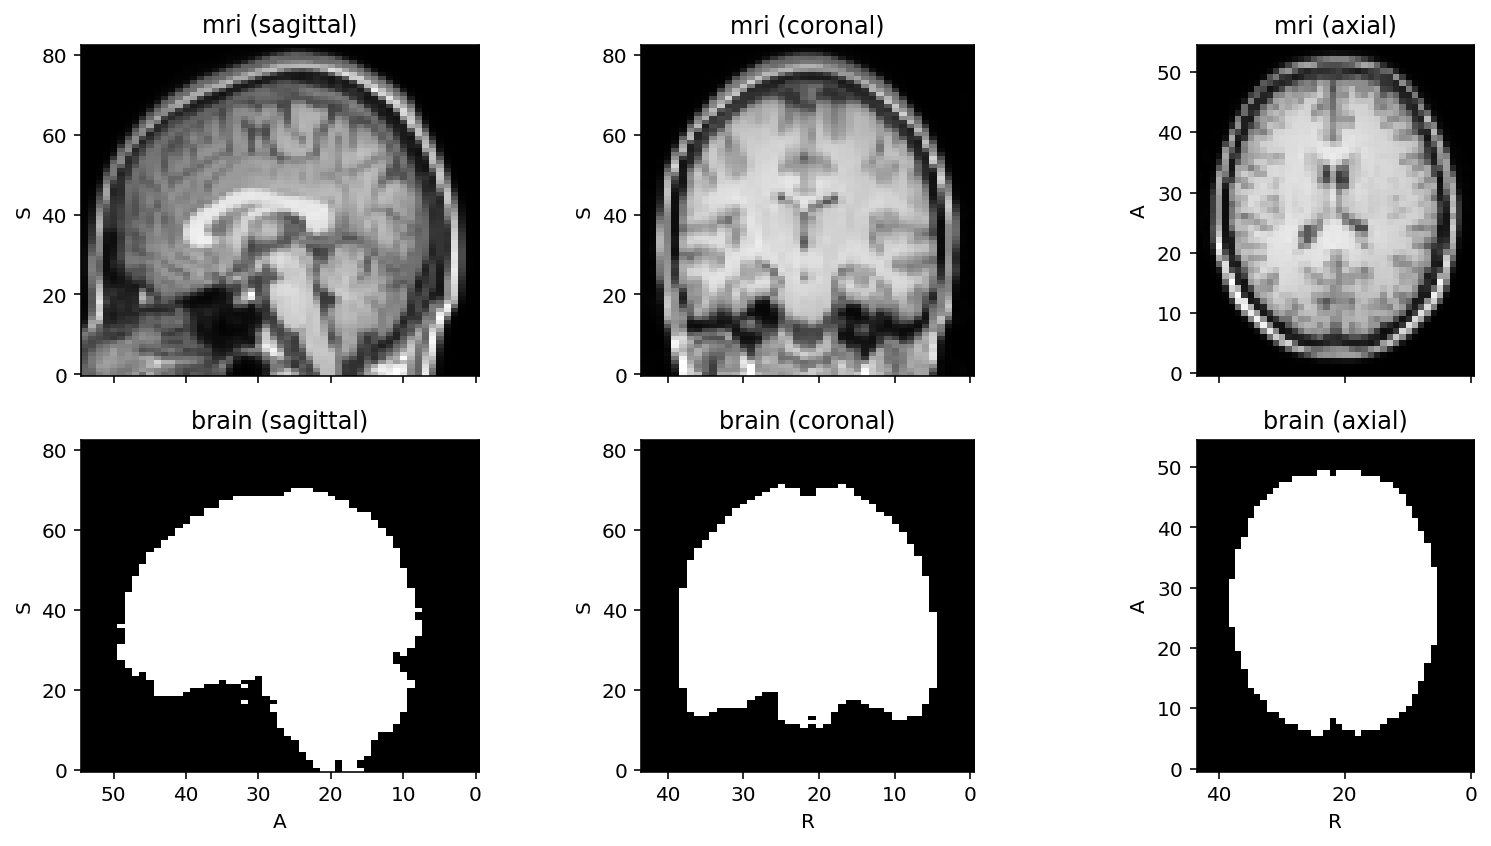

In [7]:
one_subject = dataset[0]
one_subject.plot()

In [8]:
print(one_subject)
print(one_subject.mri)
print(one_subject.brain)

Subject(Keys: ('mri', 'brain'); images: 2)
ScalarImage(shape: (1, 83, 44, 55); spacing: (2.18, 4.13, 3.95); orientation: SRA+; memory: 392.3 KiB; dtype: torch.ShortTensor)
LabelMap(shape: (1, 83, 44, 55); spacing: (2.18, 4.13, 3.95); orientation: SRA+; memory: 196.2 KiB; dtype: torch.ByteTensor)


## Training a network



In [9]:
Noisy_transform = tio.Compose([
    tio.Resample(4),
    tio.CropOrPad((48, 60, 48)),
    tio.ZNormalization(masking_method=tio.ZNormalization.mean),
    tio.RandomMotion(p=0.2),
    tio.RandomBiasField(p=0.3),
    tio.RandomNoise(p=0.5),
    tio.RandomFlip(),
    tio.OneOf({
        tio.RandomAffine(): 0.8,
        tio.RandomElasticDeformation(): 0.2,
    }),
    tio.OneHot(),
])

transform = tio.Compose([
    tio.Resample(4),
    tio.CropOrPad((48, 60, 48)),
    tio.ZNormalization(masking_method=tio.ZNormalization.mean),
    tio.OneHot(),
])

num_subjects = len(dataset)
num_training_subjects = int(training_split_ratio * num_subjects)
num_validation_subjects = num_subjects - num_training_subjects

num_split_subjects = num_training_subjects, num_validation_subjects
training_subjects, validation_subjects = torch.utils.data.random_split(subjects, num_split_subjects)

training_set = tio.SubjectsDataset(
    training_subjects, transform=transform)

validation_set = tio.SubjectsDataset(
   training_subjects , transform=Noisy_transform)

print('Training set:', len(training_set), 'subjects')
print('Validation set:', len(validation_set), 'subjects')

Training set: 509 subjects
Validation set: 509 subjects


### Deep learning stuff

In [13]:
#@title (Deep learning functions, double-click here to expand)
device = torch.device('cuda') if torch.cuda.is_available() else 'cpu'
CHANNELS_DIMENSION = 1
SPATIAL_DIMENSIONS = 2, 3, 4

class Action(enum.Enum):
    TRAIN = 'Training'
    VALIDATE = 'Validation'

def prepare_batch(x,y, device):
    inputs = x['mri'][tio.DATA].to(device)
    targets = y['mri'][tio.DATA].to(device)
    return inputs, targets

def get_dice_score(output, target, epsilon=1e-9):
    p0 = output
    g0 = target
    p1 = 1 - p0
    g1 = 1 - g0
    tp = (p0 * g0).sum(dim=SPATIAL_DIMENSIONS)
    fp = (p0 * g1).sum(dim=SPATIAL_DIMENSIONS)
    fn = (p1 * g0).sum(dim=SPATIAL_DIMENSIONS)
    num = 2 * tp
    denom = 2 * tp + fp + fn + epsilon
    dice_score = num / denom
    return dice_score

def get_dice_loss(output, target):
    return 1 - get_dice_score(output, target)

def get_model_and_optimizer(device):
    model = UNet(
        in_channels=1,
        out_classes=2,
        dimensions=3,
        num_encoding_blocks=3,
        out_channels_first_layer=8,
        normalization='batch',
        upsampling_type='linear',
        padding=True,
        activation='PReLU',
    ).to(device)
    optimizer = torch.optim.AdamW(model.parameters())
    return model, optimizer

def run_epoch(epoch_idx, action, loader, model, optimizer):
    is_training = action == Action.TRAIN
    epoch_losses = []
    times = []
    model.train(is_training)
    for batch_idx, batch in enumerate(tqdm(loader)):
        inputs, targets = prepare_batch(batch, device)
        optimizer.zero_grad()
        with torch.set_grad_enabled(is_training):
            logits = model(inputs)
            probabilities = F.softmax(logits, dim=CHANNELS_DIMENSION)
            batch_losses = get_dice_loss(probabilities, targets)
            batch_loss = batch_losses.mean()
            if is_training:
                batch_loss.backward()
                optimizer.step()
            times.append(time.time())
            epoch_losses.append(batch_loss.item())
    epoch_losses = np.array(epoch_losses)
    print(f'{action.value} mean loss: {epoch_losses.mean():0.3f}')
    return times, epoch_losses

def train(num_epochs, training_loader, validation_loader, model, optimizer, weights_stem):
    train_losses = []
    val_losses = []
    val_losses.append(run_epoch(0, Action.VALIDATE, validation_loader, model, optimizer))
    for epoch_idx in range(1, num_epochs + 1):
        print('Starting epoch', epoch_idx)
        train_losses.append(run_epoch(epoch_idx, Action.TRAIN, training_loader, model, optimizer))
        val_losses.append(run_epoch(epoch_idx, Action.VALIDATE, validation_loader, model, optimizer))
        torch.save(model.state_dict(), f'{weights_stem}_epoch_{epoch_idx}.pth')
    return np.array(train_losses), np.array(val_losses)

### Whole images

In [11]:
training_batch_size = 16
validation_batch_size = 2 * training_batch_size

training_loader = torch.utils.data.DataLoader(
    training_set,
    batch_size=training_batch_size,
    shuffle=True,
    num_workers=num_workers,
)

validation_loader = torch.utils.data.DataLoader(
    validation_set,
    batch_size=training_batch_size,
    num_workers=num_workers,
)

In [14]:
model, optimizer = get_model_and_optimizer(device)
epochs = 10
for epoch in range(epochs):
  for batch_idx, X in enumerate(tqdm(validation_loader)):
    for batch_idx, Y in enumerate(tqdm(training_loader)):
      inputs, targets = prepare_batch(X,Y, device)
      prediction = model(inputs)
      



  0%|          | 0/32 [00:00<?, ?it/s]

  0%|          | 0/32 [00:00<?, ?it/s]

/usr/local/lib/python3.7/dist-packages/torch/_tensor.py:575: UserWarning: floor_divide is deprecated, and will be removed in a future version of pytorch. It currently rounds toward 0 (like the 'trunc' function NOT 'floor'). This results in incorrect rounding for negative values.
To keep the current behavior, use torch.div(a, b, rounding_mode='trunc'), or for actual floor division, use torch.div(a, b, rounding_mode='floor'). (Triggered internally at  /pytorch/aten/src/ATen/native/BinaryOps.cpp:467.)
  return torch.floor_divide(self, other)


  0%|          | 0/32 [00:00<?, ?it/s]

  0%|          | 0/32 [00:00<?, ?it/s]

  0%|          | 0/32 [00:00<?, ?it/s]

  0%|          | 0/32 [00:00<?, ?it/s]

  0%|          | 0/32 [00:00<?, ?it/s]

  0%|          | 0/32 [00:00<?, ?it/s]

  0%|          | 0/32 [00:00<?, ?it/s]

  0%|          | 0/32 [00:00<?, ?it/s]

  0%|          | 0/32 [00:00<?, ?it/s]

  0%|          | 0/32 [00:00<?, ?it/s]

  0%|          | 0/32 [00:00<?, ?it/s]

  0%|          | 0/32 [00:00<?, ?it/s]

  0%|          | 0/32 [00:00<?, ?it/s]

  0%|          | 0/32 [00:00<?, ?it/s]

  0%|          | 0/32 [00:00<?, ?it/s]

  0%|          | 0/32 [00:00<?, ?it/s]

  0%|          | 0/32 [00:00<?, ?it/s]

  0%|          | 0/32 [00:00<?, ?it/s]

  0%|          | 0/32 [00:00<?, ?it/s]

  0%|          | 0/32 [00:00<?, ?it/s]

  0%|          | 0/32 [00:00<?, ?it/s]

  0%|          | 0/32 [00:00<?, ?it/s]

  0%|          | 0/32 [00:00<?, ?it/s]

  0%|          | 0/32 [00:00<?, ?it/s]

  0%|          | 0/32 [00:00<?, ?it/s]

  0%|          | 0/32 [00:00<?, ?it/s]

  0%|          | 0/32 [00:00<?, ?it/s]

  0%|          | 0/32 [00:00<?, ?it/s]

  0%|          | 0/32 [00:00<?, ?it/s]

  0%|          | 0/32 [00:00<?, ?it/s]

  0%|          | 0/32 [00:00<?, ?it/s]

In [ ]:
import torch.nn as nn

In [ ]:
loss = nn.MSELoss()

In [ ]:
l = loss(p,targets)
l

#### Train

#### Test

In [ ]:
batch = next(iter(validation_loader))
model.eval()
inputs, targets = prepare_batch(batch, device)
FIRST = 0
FOREGROUND = 1
with torch.no_grad():
    probabilities = model(inputs).softmax(dim=1)[:, FOREGROUND:].cpu()
affine = batch['mri'][tio.AFFINE][0].numpy()
subject = tio.Subject(
    mri=tio.ScalarImage(tensor=batch['mri'][tio.DATA][FIRST], affine=affine),
    label=tio.LabelMap(tensor=batch['brain'][tio.DATA][FIRST], affine=affine),
    predicted=tio.ScalarImage(tensor=probabilities[FIRST], affine=affine),
)
subject.plot(figsize=(9, 8), cmap_dict={'predicted': 'RdBu_r'})